# Where's Waldo Data Augmentation

The data was collected from [this](https://www.kaggle.com/residentmario/wheres-waldo) Kaggle competition. However, the data for this competition comes in the form of images where waldo is there or not there.

So, I manually created bounding boxes and stored them in the `boxes-128.json` file.

Once I had the bounding boxes, I simply programmatically mapped them onto the original Where's Waldo maps to feed into the network.

In [1]:
import IPython.core.display as di

def toggle_code():
    di.display_html(
        """<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">
            Toggle code
        </button>""",
        raw=True,
    )

toggle_code()

Toggle code

In [2]:
import logging
import json
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from matplotlib import patches
from multiprocessor import Multiprocessor
from PIL import Image

log = logging.getLogger(__name__)

## Example Bounding Boxes

Here are three examples of bounding boxes that I manually curated from the data.

In [3]:
with open("boxes.json") as file:
    boxes =json.loads(file.read())

In [4]:
originals = {
    waldo: np.array(Image.open(os.path.join("data", "original-images", waldo)))
    for waldo in os.listdir(os.path.join("data", "original-images"))
    if waldo.endswith(".jpg") and waldo in boxes
}

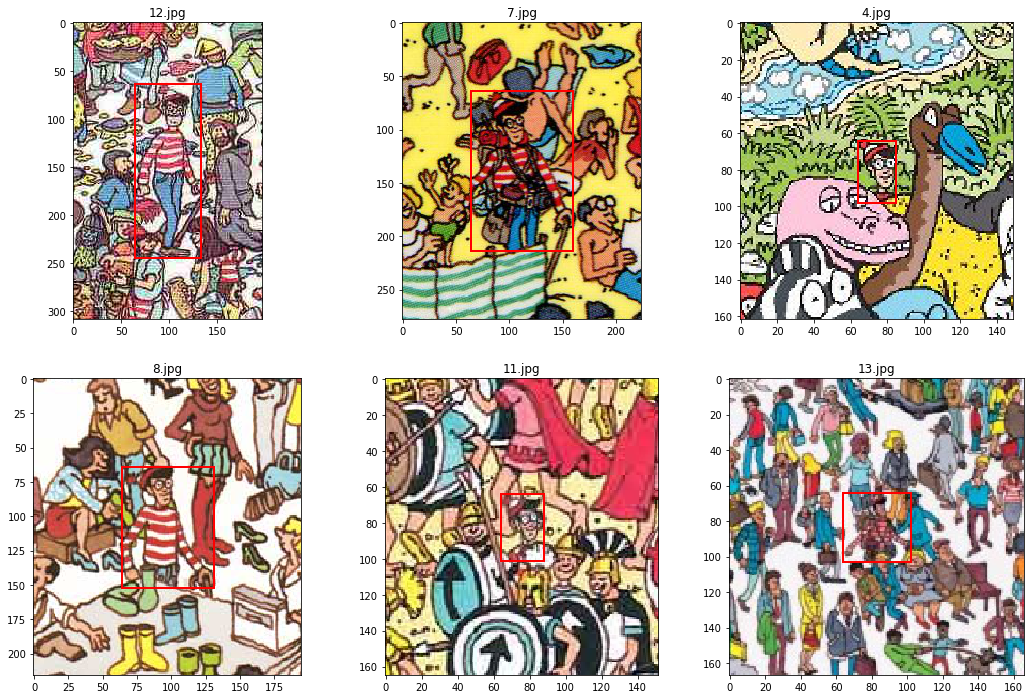

In [5]:
num_rows = 2 # len(boxes_128) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
for i, (waldo, image) in enumerate(originals.items()):
    if int(i//3) >= num_rows:
        break
    ax = axes[int(i//3), int(i%3)]
    x, y, w, h = boxes[waldo]
    ax.imshow(image[y-64:y+h+64, x-64:x+w+64])
    ax.add_patch(patches.Rectangle((64, 64), w, h, linewidth=2, edgecolor='r', facecolor='none'))
    ax.set_title(waldo)

plt.show()

## Data Augmentation

There are only 18 examples in the dataset. This is nowhere near enough data to meet our needs. So, what we will do is generate additional images by making random crops of the 18 images that we do have.

In [6]:
data = []

original_names = list(originals.keys())

augment_size = 100
while augment_size >= 0:
    np.random.shuffle(original_names)
    for name in original_names:
        image = originals[name]
        crop_width = int(image.shape[1] * np.random.uniform(0.7, 0.9))
        crop_height = int(image.shape[0] * np.random.uniform(0.7, 0.9))
        crop_x = np.random.randint(image.shape[1] - crop_width)
        crop_y = np.random.randint(image.shape[0] - crop_height)
        
        data.append({
            "name": name,
            "crop": {
                "x": crop_x,
                "y": crop_y,
                "w": crop_width,
                "h": crop_height,   
            },
        })
        
        box_x, box_y, box_width, box_height = boxes[name]        
        new_box_x = max(box_x - crop_x, 0)
        new_box_y = max(box_y - crop_y, 0)
        new_box_width = min(box_width, crop_x + crop_width - box_x, box_x + box_width - crop_x)
        new_box_height = min(box_height, crop_y + crop_height - box_y, box_y + box_height - crop_y)
        
        if new_box_width > 0 and new_box_height > 0:
            data[-1]["box"] = {
                "x": new_box_x,
                "y": new_box_y,
                "w": new_box_width,
                "h": new_box_height,
            }
        
    
    augment_size -= 1
    
print("Number of Augmented Images: ", len(data))
with open("data.json", "w") as file:
    file.write(json.dumps(data))

Number of Augmented Images:  1818


I augmented the each original image 100 times. So, we are left with 1818 samples to train with.

### Sanity Check

Use the following code to verify if the data was augmented correctly.

In [ ]:
def sanity_check(r):
    name = data[r]['name']
    dims = data[r]['crop']
    x, y, w, h = dims['x'], dims['y'], dims['w'], dims['h']
    image = originals[name][y:y+h, x:x+w]

    print("original.shape:  ", originals[name].shape)
    print("crop.shape:      ", image.shape)
    print("crop.dims:       ", dims)
    print("original_box.shape:  ", boxes[name])

    fig, ax = plt.subplots(1)

    if "box" in data[r]:
        box = data[r]['box']
        x, y, w, h = box['x'], box['y'], box['w'], box['h']
        print("crop_box.shape:      ", box)
        vb = min(y, 64)
        hb = min(x, 64)
        ax.imshow(image[y-vb:y+h+64, x-hb:x+w+64])
        ax.add_patch(patches.Rectangle((hb, vb), w, h, linewidth=2, edgecolor='r', facecolor='none'))

    else:
        ax.imshow(image)

    plt.show()
    
# sanity_check(np.random.randint(len(data)))